# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

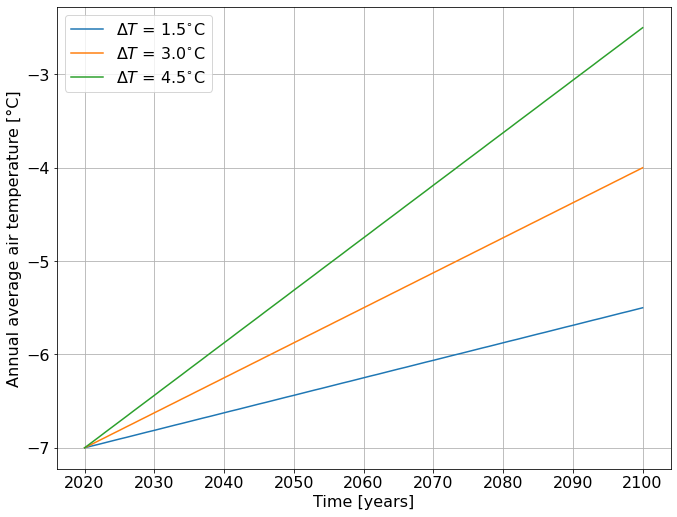

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

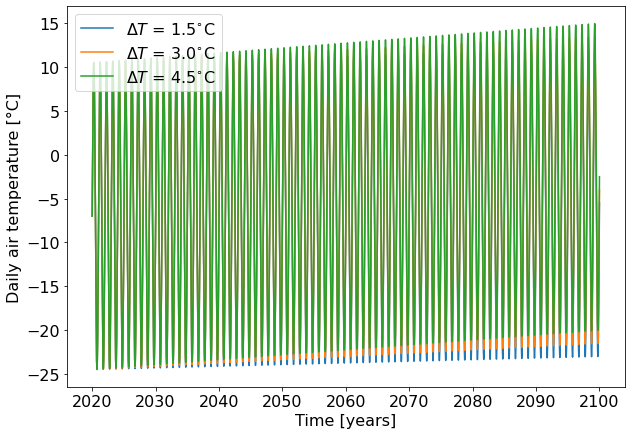

In [6]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
z = np.arange(dz/2, zs, dz)
Nz = z.size

### 5. Setup Initial Condition

In [8]:
# a simple initial condition
Ts0 = Tbottom*np.ones((Nz,1))

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [10]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(dz**2)
print('Diffusion number '+str(alpha))

# Obtain Delta matrix
Delta2 = np.diag(-2.0*np.ones((Nz))) + np.diag(np.ones((Nz-1)),1) + np.diag(np.ones((Nz-1)),-1)

I = np.eye(Nz)
A = I - alpha*Delta2
A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.41081821294077364


### 7. Preallocate Storage for Soil Temperatures

In [11]:
# For different degree changes
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [15]:
# take inverse of A matrix out
Ainv = np.linalg.pinv(A)

# for 1.5 degree case
for i in np.arange(Nt):
    if(i==0):
        Tsi = Ts0
    else:
        Tsi = Ts_15[:,i-1]
        Tsi[0] = Ttop_15[i]
        Tsi[-1] = Tbottom
    
    Tsip1 = np.matmul(Ainv,Tsi)
    
    Ts_15[:,i] = np.squeeze(Tsip1)

# for 3.0 degree case
for i in np.arange(Nt):
    if(i==0):
        Tsi = Ts0
    else:
        Tsi = Ts_30[:,i-1]
        Tsi[0] = Ttop_30[i]
        Tsi[-1] = Tbottom
    
    Tsip1 = np.matmul(Ainv,Tsi)
    
    Ts_30[:,i] = np.squeeze(Tsip1)
    
# for 4.5 degree case
for i in np.arange(Nt):
    if(i==0):
        Tsi = Ts0
    else:
        Tsi = Ts_45[:,i-1]
        Tsi[0] = Ttop_45[i]
        Tsi[-1] = Tbottom
    
    Tsip1 = np.matmul(Ainv,Tsi)
    
    Ts_45[:,i] = np.squeeze(Tsip1)

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

### Q1
A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.

C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Ei

Text(0.5, 1.0, '$\\Delta T$ = 4.5${}^{\\circ}$C')

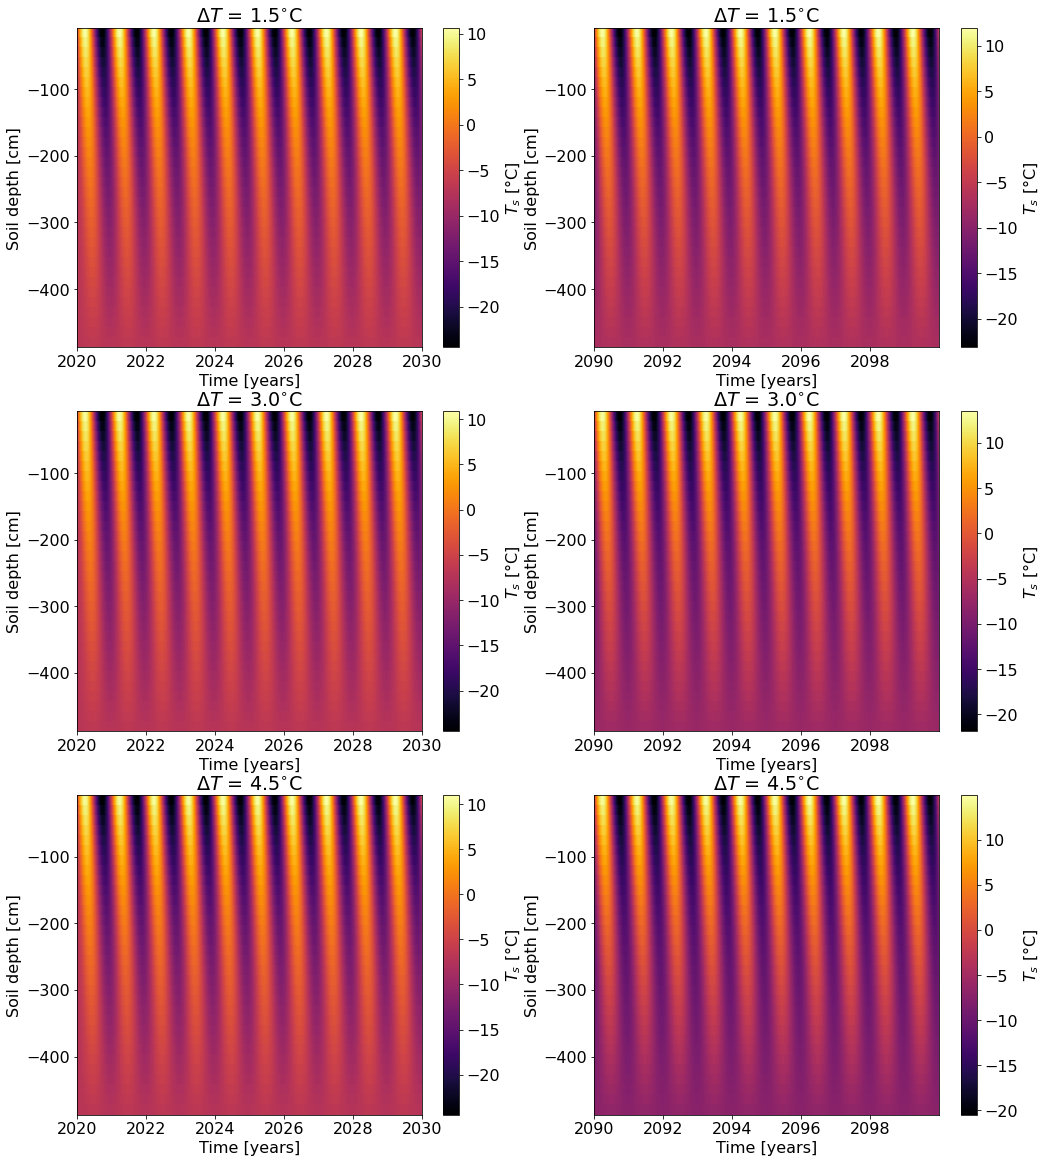

In [38]:

# find the index of 2030 and 2090
iy2030 = (np.absolute(t-2030.001)).argmin()
iy2090 = (np.absolute(t-2090)).argmin()

tt2030,zz2030 = np.meshgrid(t[0:iy2030],z)
tt2090,zz2090 = np.meshgrid(t[iy2090:],z)

# begin plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(17,20))

plt.subplot(3,2,1)
plt.pcolormesh(tt2030,-zz2030,Ts_15[:,0:iy2030],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 1.5${}^{\circ}$C')
plt.subplot(3,2,2)
plt.pcolormesh(tt2090,-zz2090,Ts_15[:,iy2090:],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 1.5${}^{\circ}$C')

plt.subplot(3,2,3)
plt.pcolormesh(tt2030,-zz2030,Ts_30[:,0:iy2030],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 3.0${}^{\circ}$C')
plt.subplot(3,2,4)
plt.pcolormesh(tt2090,-zz2090,Ts_30[:,iy2090:],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 3.0${}^{\circ}$C')

plt.subplot(3,2,5)
plt.pcolormesh(tt2030,-zz2030,Ts_45[:,0:iy2030],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 4.5${}^{\circ}$C')
plt.subplot(3,2,6)
plt.pcolormesh(tt2090,-zz2090,Ts_45[:,iy2090:],cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 4.5${}^{\circ}$C')


### Q2
A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 

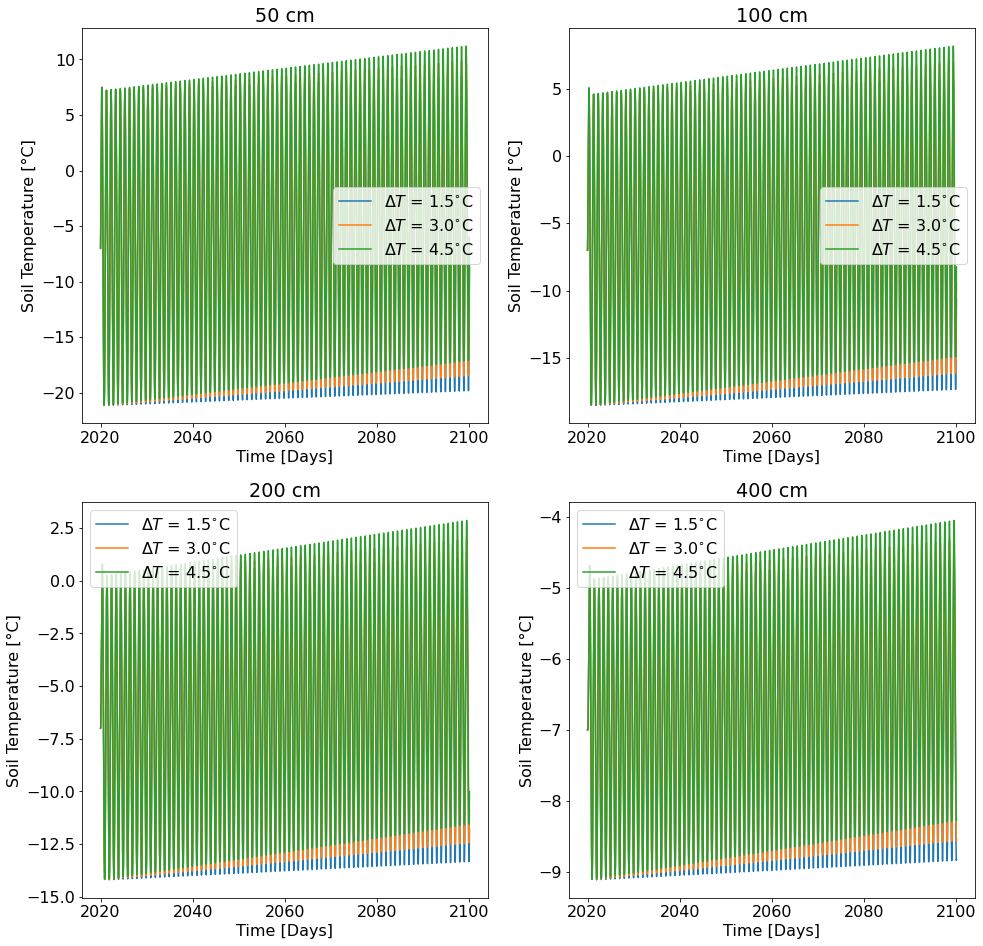

In [43]:
# find index for 50cm, 100cm, 200cm and 400cm
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()


plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(t,Ts_15[iz50,:],label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t,Ts_30[iz50,:],label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t,Ts_45[iz50,:],label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.title('50 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t,Ts_15[iz100,:],label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t,Ts_30[iz100,:],label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t,Ts_45[iz100,:],label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.title('100 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t,Ts_15[iz200,:],label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t,Ts_30[iz200,:],label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t,Ts_45[iz200,:],label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.title('200 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

plt.subplot(2,2,4)
plt.plot(t,Ts_15[iz400,:],label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t,Ts_30[iz400,:],label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t,Ts_45[iz400,:],label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.title('400 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()


### Q3
A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered co

Text(0.5, 1.0, '$\\Delta T$ = 1.5${}^{\\circ}$C')

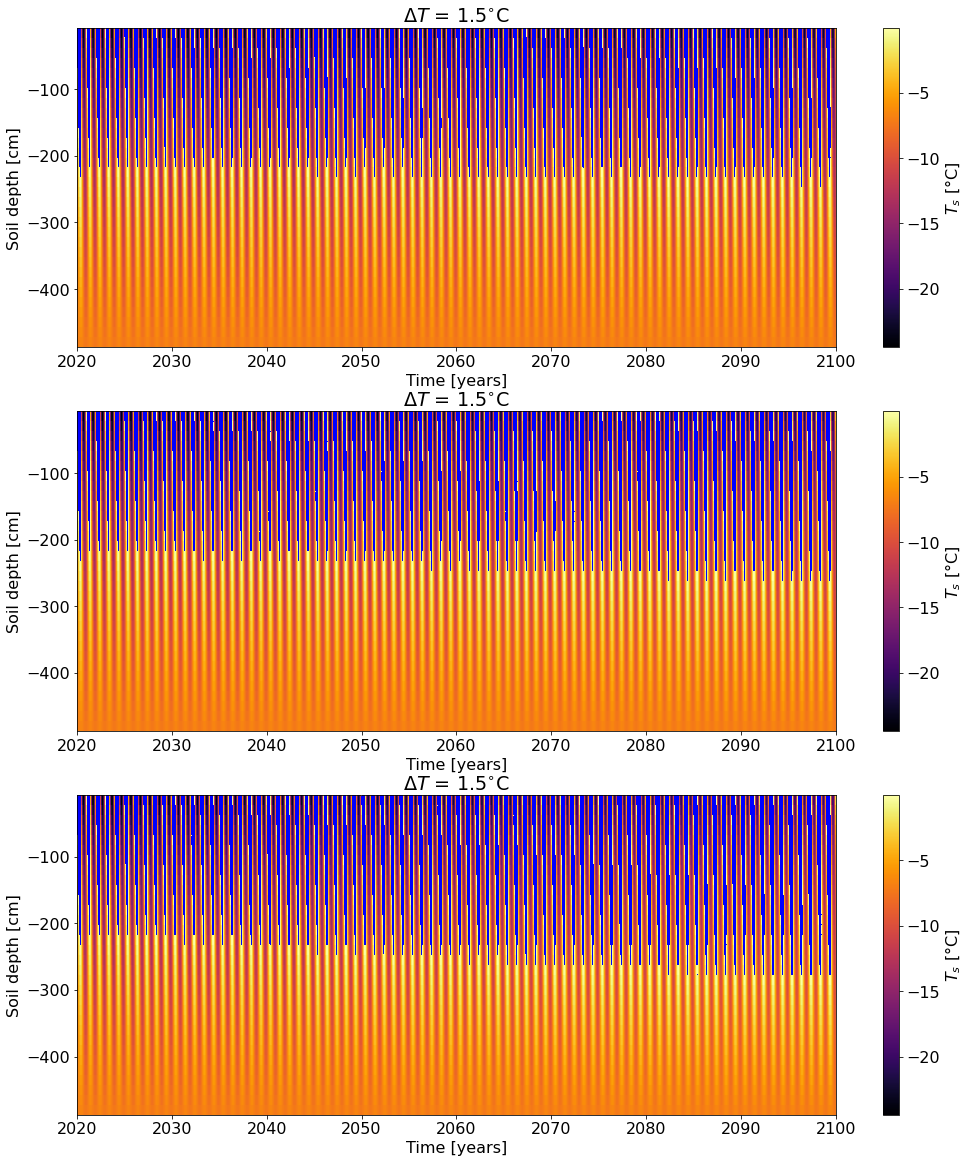

In [50]:
#plot the active layer for each scenario
tt,zz = np.meshgrid(t,z)

Ts_15_frozen = np.ma.masked_where(Ts_15>0.0,Ts_15)
Ts_30_frozen = np.ma.masked_where(Ts_30>0.0,Ts_30)
Ts_45_frozen = np.ma.masked_where(Ts_45>0.0,Ts_45)

# begin plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(17,20))

plt.subplot(3,1,1)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tt,-zz,Ts_15_frozen,cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 1.5${}^{\circ}$C')


plt.subplot(3,1,2)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tt,-zz,Ts_30_frozen,cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 1.5${}^{\circ}$C')


plt.subplot(3,1,3)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tt,-zz,Ts_45_frozen,cmap=current_cmap) 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
plt.title('$\Delta T$ = 1.5${}^{\circ}$C')
